In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, LinearRegression, Ridge, TheilSenRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline

from scipy import signal

https://stackoverflow.com/questions/77708524/python-fitting-polynomial-to-natural-log-then-reversing-the-transformation-back

In [2]:
np.random.seed(12345)
x = np.linspace(-1, 1, 50).reshape(-1, 1)
P = np.poly1d([6, 5, 4, 3, 2, 10])
y = P(x[:, 0])
n = 0.0005 * np.random.randn(y.size)
yn = y + n

In [3]:
pipeline_lin = Pipeline([
    ("transformer", PolynomialFeatures(5)),
    ("model", LinearRegression(fit_intercept=False))
])

In [4]:
pipeline_lin.fit(x, yn)

Pipeline(steps=[('transformer', PolynomialFeatures(degree=5)),
                ('model', LinearRegression(fit_intercept=False))])

In [5]:
pipeline_lin["model"].coef_

array([10.00002261,  1.99951831,  2.99923639,  3.99891665,  5.00099905,
        6.00188615])

In [6]:
pipeline_log = Pipeline([
    ("transformer", PolynomialFeatures(5)),
    ("model",
         TransformedTargetRegressor(
             regressor=LinearRegression(fit_intercept=False),
             func=np.log,
             inverse_func=np.exp
         )
    )
])

In [7]:
pipeline_log.fit(x, yn)

Pipeline(steps=[('transformer', PolynomialFeatures(degree=5)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression(fit_intercept=False)))])

In [8]:
pipeline_log["model"].regressor_.coef_

array([ 2.29255947,  0.20050235,  0.47737643,  0.37136111, -0.15000675,
        0.22940872])

In [9]:
pipeline_gpr = Pipeline([
    ("model",
         TransformedTargetRegressor(
             regressor=GaussianProcessRegressor(
                 kernel=1.0*RBF(),
                 alpha=0.01
             ),
             func=np.log,
             inverse_func=np.exp
         )
    )
])

In [10]:
pipeline_gpr.fit(x, yn)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=GaussianProcessRegressor(alpha=0.01,
                                                                               kernel=1**2 * RBF(length_scale=1))))])

In [11]:
xlin = np.linspace(-1, 1, 200).reshape(-1, 1)
yh_lin = pipeline_lin.predict(xlin)
yh_log = pipeline_log.predict(xlin)
yh_gpr = pipeline_log.predict(xlin)

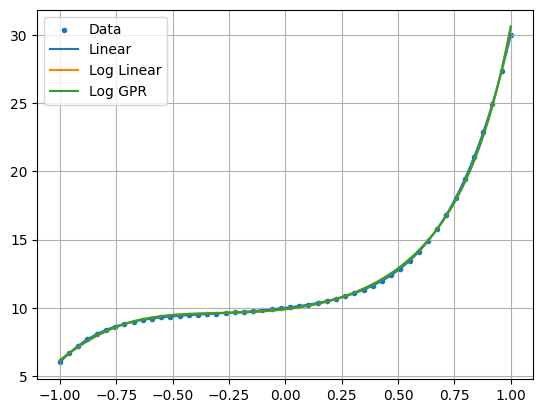

In [12]:
fig, axe = plt.subplots()
axe.scatter(x, yn, marker=".", label="Data")
axe.plot(xlin, yh_lin, label="Linear")
axe.plot(xlin, yh_log, label="Log Linear")
axe.plot(xlin, yh_gpr, label="Log GPR")
axe.legend()
axe.grid()

In [13]:
yh_gpr = pipeline_gpr.predict(xlin)

In [14]:
dx = xlin[1,0] - xlin[0,0]
yh_lin_d2 = signal.savgol_filter(yh_lin, 15, 3, deriv=2, delta=dx)
yh_log_d2 = signal.savgol_filter(yh_log, 15, 3, deriv=2, delta=dx)
yh_gpr_d2 = signal.savgol_filter(yh_gpr, 15, 3, deriv=2, delta=dx)

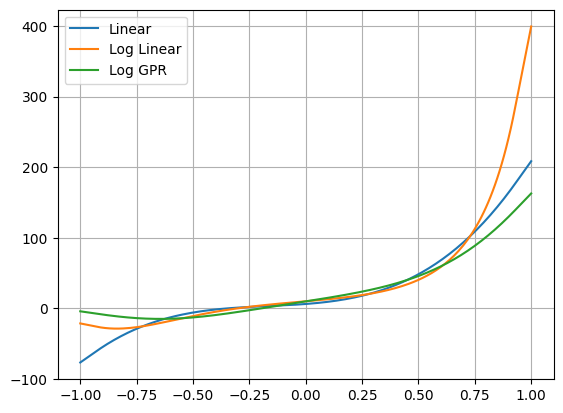

In [15]:
fig, axe = plt.subplots()
axe.plot(xlin, yh_lin_d2, label="Linear")
axe.plot(xlin, yh_log_d2, label="Log Linear")
axe.plot(xlin, yh_gpr_d2, label="Log GPR")
axe.legend()
axe.grid()

In [16]:
def fit_diff(x, y, poly_order=5, resolution=200):
    pipeline = Pipeline([
        ("transformer", PolynomialFeatures(poly_order)),
        ("model", LinearRegression(fit_intercept=False))
    ])
    xlin = np.linspace(x.min(), x.max(), resolution).reshape(-1, 1)
    yhat = pipeline.fit(x, y).predict(xlin)
    dx = xlin[1, 0] - xlin[0, 0]
    dy2dx2 = signal.savgol_filter(yhat, 15, 3, deriv=2, delta=dx)
    return dy2dx2

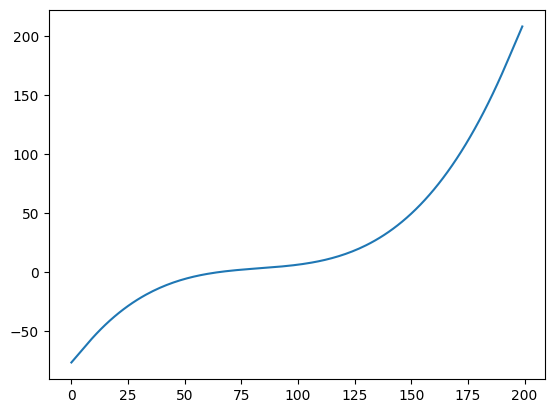

In [17]:
fig, axe = plt.subplots()
axe.plot(fit_diff(x, yn))


In [18]:
pipeline = Pipeline([
    ("transformer", PolynomialFeatures(5)),
    ("model", TheilSenRegressor(fit_intercept=False))
])

In [19]:
pipeline.fit(x, yn)

Pipeline(steps=[('transformer', PolynomialFeatures(degree=5)),
                ('model', TheilSenRegressor(fit_intercept=False))])

In [20]:
pipeline["model"].coef_


array([10.00000763,  1.9994623 ,  2.99928083,  3.99916195,  5.00073624,
        6.00172763])

In [21]:
Phat = np.poly1d(pipeline["model"].coef_[::-1])
Phat_xx = Phat.deriv(m=2)

In [22]:
Phat

poly1d([ 6.00172763,  5.00073624,  3.99916195,  2.99928083,  1.9994623 ,
       10.00000763])

In [23]:
Phat_xx

poly1d([120.03455265,  60.00883489,  23.99497169,   5.99856166])

In [24]:
yhat = pipeline.predict(xlin)
yp = Phat(np.squeeze(xlin))
y2 = Phat_xx(np.squeeze(xlin))

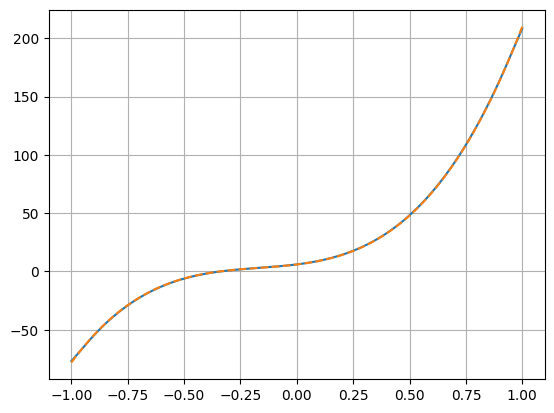

In [28]:
fig, axe = plt.subplots()
axe.plot(xlin, yh_lin_d2)
axe.plot(xlin, y2, linestyle="--")
axe.grid()